In [134]:
import pandas as pd
import nltk
from nltk.util import ngrams
nltk.download('punkt')
nltk.download('vader_lexicon')

In [169]:
# read data
reviews_df = pd.read_csv('./scripts/FinalProject/review_data.csv',index_col=[0])
reviews_df = reviews_df.loc[reviews_df.bank_name == 'Ally Bank'].reset_index(drop = True)
reviews_df.head()
# len(reviews_df)

,summary,review_id,bank_id,bank_name,user_id,rating,review,date_posted
0,Ally Bank Online Deposits,40107,277,Ally Bank,65053,1,Be advised Ally Bank does not accept any money...,2019-11-23
1,"Extensive Hold Times, To Use Your Own Money",39617,277,Ally Bank,64905,2,"Zelle payment - payments placed on hold, requi...",2019-11-19
2,"Nice People, But Incompetent...",39341,277,Ally Bank,24865,1,Every single transaction I have attempted at A...,2019-10-24
3,IRA Issues,39305,277,Ally Bank,63876,1,Do not deal with their IRA department. I moved...,2019-10-21
4,Love Ally Overall But,39256,277,Ally Bank,58796,5,Been with ally 7 plus years. Have had at least...,2019-10-17


In [170]:
# create new column
reviews_df["is_bad_review"] = reviews_df["rating"].apply(lambda x: 1 if x < 3 else 0)
# pick most relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]
reviews_df['review']= reviews_df['review'].apply(str)
#reviews_df['review'].dropna(inplace=True)
reviews_df.head(5)

,review,is_bad_review
0,Be advised Ally Bank does not accept any money...,1
1,"Zelle payment - payments placed on hold, requi...",1
2,Every single transaction I have attempted at A...,1
3,Do not deal with their IRA department. I moved...,1
4,Been with ally 7 plus years. Have had at least...,0


### Clean Data

In [171]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer,SnowballStemmer
import re
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

In [172]:
def preprocess(text):
   # split into words
    text = word_tokenize(text)
    # convert to lower case
    text= [w.lower() for w in text]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    text = [w.translate(table) for w in text]
    # remove remaining tokens that are not alphabetic
    text = [word for word in text if word.isalpha()]
    meaningless_words = ['br', 'ally', 'suntrust', 'bofa', 'citi', 'capital one', 'capitalone360',
                        'bank america']
    #remove meaningless word
    text = [word for word in text if word.lower() not in meaningless_words]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # stemming of words
#     porter = PorterStemmer()
#     text = [porter.stem(word) for word in text]
    
    # join all
    text = " ".join(text)
    return(text)

In [173]:
#Checking with sample review
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem.porter import *
import numpy as np
import nltk

In [174]:
doc_sample = reviews_df.loc[4,'review']
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Been', 'with', 'ally', '7', 'plus', 'years.', 'Have', 'had', 'at', 'least', '12', 'different', 'CD', 'and', 'a', 'reg', 'saving', 'acct.', "I've", 'been', 'able', 'to', 'transfer', 'each', 'CD', 'when', "it's", 'up', 'for', 'renewal', 'with', 'no', 'problems', '<br/><br/>Only', 'neg', 'is', 'in', 'last', '9-12', 'months', 'they', "haven't", 'been', 'as', 'competitive', 'as', 'other', 'online', 'banks.', 'I', 'have', 'now', '3', 'other', 'banks', 'because', 'of', 'that', 'but', 'still', 'have', '5', 'CD', 'with', 'ally<br/><br/>When', 'each', 'on', 'comes', 'due', 'will', 'see', 'rates.', '<br/><br/>And', '98%', 'if', 'time', 'I', 'call,', 'wait', 'time', 'under', '5', 'minutes<br/><br/>Yes', 'one', 'time', 'when', 'they', 'offered', 'a', 'GREAT', '14', 'month', 'CD,', 'everyone', 'wanted', 'that', 'and', 'wait', 'time', 'was', '15', 'minutes.', 'No', 'big', 'deal']


 tokenized and lemmatized document: 
plus years least different cd reg saving acct able transfer c

In [175]:
# create new review column(clean)
reviews_df['review_clean'] = pd.DataFrame(reviews_df['review'].map(preprocess))
reviews_df.head(1)

,review,is_bad_review,review_clean
0,Be advised Ally Bank does not accept any money...,1,advised bank accept money orders including us ...


### Feature Engineering

In [176]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review_clean"].apply(lambda x: sid.polarity_scores(x))
# print(reviews_df["sentiments"])
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)
# reviews_df.drop(columns  =['sentiments'], inplace = True)


In [177]:
reviews_df.columns
reviews_df.head(5)

,review,is_bad_review,review_clean,neg,neu,pos,compound
0,Be advised Ally Bank does not accept any money...,1,advised bank accept money orders including us ...,0.104,0.783,0.113,0.0516
1,"Zelle payment - payments placed on hold, requi...",1,zelle payment payments placed hold required mi...,0.082,0.820,0.098,0.1027
2,Every single transaction I have attempted at A...,1,every single transaction attempted last two ye...,0.053,0.855,0.092,0.3612
3,Do not deal with their IRA department. I moved...,1,deal ira department moved ira sep june time co...,0.022,0.941,0.036,0.3818
4,Been with ally 7 plus years. Have had at least...,0,plus years least different cd reg saving acct ...,0.051,0.789,0.160,0.7003


In [178]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review_clean"].apply(lambda x: len(x))

In [179]:
# add number of words column
reviews_df["nb_words"] = reviews_df["review_clean"].apply(lambda x: len(x.split(" ")))

In [180]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]


In [181]:
# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [182]:
# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [183]:
reviews_df.head()

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,Be advised Ally Bank does not accept any money...,1,advised bank accept money orders including us ...,0.104,0.783,0.113,0.0516,141,20,0.392874,-0.276597,-0.115732,-0.548981,-0.020388
1,"Zelle payment - payments placed on hold, requi...",1,zelle payment payments placed hold required mi...,0.082,0.820,0.098,0.1027,173,22,0.322267,-0.321609,-0.044720,-0.432353,-0.168304
2,Every single transaction I have attempted at A...,1,every single transaction attempted last two ye...,0.053,0.855,0.092,0.3612,618,83,0.972556,-0.702556,-0.346901,-1.607823,-0.280501
3,Do not deal with their IRA department. I moved...,1,deal ira department moved ira sep june time co...,0.022,0.941,0.036,0.3818,782,108,1.077316,-0.846297,-0.479342,-1.703481,-0.425257
4,Been with ally 7 plus years. Have had at least...,0,plus years least different cd reg saving acct ...,0.051,0.789,0.160,0.7003,265,46,0.079493,-0.105325,-0.074775,-0.292852,-0.133128


### Exploratory Data Analysis

In [184]:
# show is_bad_review distribution
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.783784
1    0.216216
Name: is_bad_review, dtype: float64

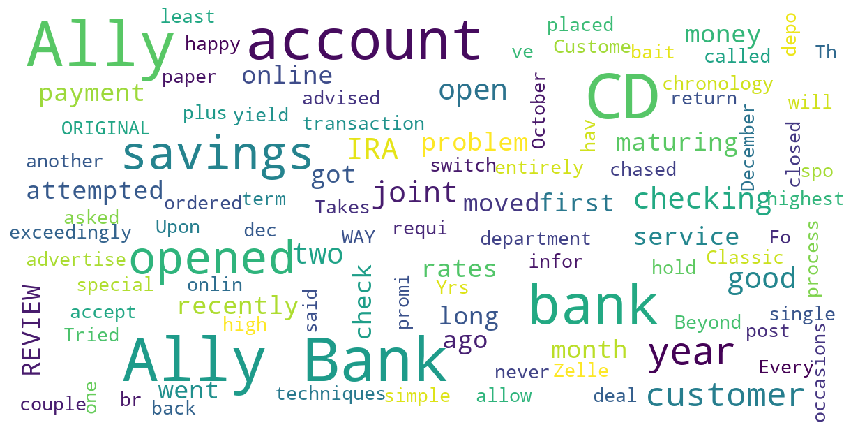

In [213]:
# wordcloud function
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 100,
        max_font_size = 30, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 15)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

In [186]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
515,I really love this bank. I've used them for a ...,0.738
141,Great bank if you like having your money held ...,0.557
589,Ally banking has been a breath of fresh air wi...,0.522
157,Ally Bank was my first experience with online ...,0.493
417,I have been banking with Ally for over 3 years...,0.479
588,Ally Bank's philosophy is to ensure the consum...,0.473
579,This bank has good telephone customer service....,0.470
394,I initially chose Ally because they appeared t...,0.464
650,"I'm not a fan of the banking industry, but thu...",0.461
316,I have had an online savings account with Ally...,0.459


In [187]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
403,What a nightmare! Their fraud department is ju...,0.503
609,Their customer service is all outsourced. Horr...,0.368
641,I had quite a few negative experiences with Al...,0.308
632,"Spent 2 weeks setting up account, sending in s...",0.302
126,"call wait time used to be a few minutes, but b...",0.302
587,My auto loan is through Ally. I've had not tro...,0.290
595,The worst customer service in my life. One dep...,0.289
37,"With CIT now at a stunning 2.45%, Ally needs t...",0.279
528,I got with this bank four years ago. I had to ...,0.262
636,I switched to Ally from Wells Fargo since they...,0.253


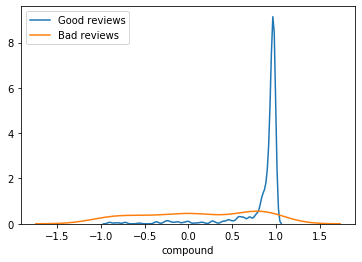

In [188]:
# plot sentiment distribution for positive and negative reviews
import seaborn as sns
for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

### Model Selection

In [189]:
reviews_df.columns

Index(['review', 'is_bad_review', 'review_clean', 'neg', 'neu', 'pos',
       'compound', 'nb_chars', 'nb_words', 'doc2vec_vector_0',
       'doc2vec_vector_1', 'doc2vec_vector_2', 'doc2vec_vector_3',
       'doc2vec_vector_4'],
      dtype='object')

In [190]:
# feature selection
label = "is_bad_review"
vectors = [ 'neg', 'neu', 'pos',
       'compound', 'nb_chars', 'nb_words','doc2vec_vector_0',
       'doc2vec_vector_1', 'doc2vec_vector_2', 'doc2vec_vector_3',
       'doc2vec_vector_4']
# ignore_cols = [label, "review", "review_clean"]
# features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[vectors], reviews_df[label], test_size = 0.30, random_state = 42)




In [191]:
text_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [192]:
# combined_df = pd.concat([X_train, X_test])
predictions = text_classifier.predict(X_test)
# y_test = y_train
# combined_y = y_train.append(y_test)
# y_test = combined_y

In [193]:
print(list(predictions).count(1))
print(list(predictions).count(0))

41
170


In [194]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[156  12]
 [ 14  29]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       168
           1       0.71      0.67      0.69        43

    accuracy                           0.88       211
   macro avg       0.81      0.80      0.81       211
weighted avg       0.87      0.88      0.88       211

0.8767772511848341


In [195]:
# show feature importance
feature_importances_df = pd.DataFrame({"feature": vectors, "importance": text_classifier.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
3,compound,0.233483
2,pos,0.192225
0,neg,0.093126
7,doc2vec_vector_1,0.070537
9,doc2vec_vector_3,0.070194
1,neu,0.065212
6,doc2vec_vector_0,0.064505
8,doc2vec_vector_2,0.060623
10,doc2vec_vector_4,0.054504
4,nb_chars,0.054072


# Predicting for entire one bank review data

In [205]:
combined_df = pd.concat([X_train, X_test])
combined_df.sort_index(inplace = True)
predictions = text_classifier.predict(combined_df)
# combined_y = y_train.append(y_test)
combined_df['predictions'] = predictions
predicted_df = pd.merge(combined_df['predictions'], reviews_df['review_clean'], left_index = True, right_index = True)
# for idx in predicted_df.index:
#     if idx> 4:
#         break
#     print(predicted_df.loc[idx, 'review_clean'], "--------", predicted_df.loc[idx, 'predictions'])
pos_predicted_df = predicted_df.loc[predicted_df.predictions == 0]
neg_predicted_df = predicted_df.loc[predicted_df.predictions == 1]
pos_words_list = []
neg_words_list = []

for idx in pos_predicted_df.index:
    review_words_list = pos_predicted_df.loc[idx, 'review_clean' ].split(' ')
    pos_words_list = pos_words_list + review_words_list
pos_words_list_2 = list(ngrams(pos_words_list, 2))
pos_words_list_3 = list(ngrams(pos_words_list, 3))
                        
for idx in neg_predicted_df.index:
    review_words_list = neg_predicted_df.loc[idx, 'review_clean' ].split(' ')
    neg_words_list = neg_words_list + review_words_list
neg_words_list_2 = list(ngrams(neg_words_list, 2))
neg_words_list_3 = list(ngrams(neg_words_list, 3))

In [209]:
pos_uni_counts = {}
pos_bi_counts = {}
pos_tri_counts = {}
neg_uni_counts = {}
neg_bi_counts = {}
neg_tri_counts = {}
for word in set(pos_words_list):
    pos_uni_counts[word] = pos_words_list.count(word)
for word in set(pos_words_list_2):
    pos_bi_counts[word] = pos_words_list_2.count(word)
for word in set(pos_words_list_3):
    pos_tri_counts[word] = pos_words_list_3.count(word)
    
for word in set(neg_words_list):
    neg_uni_counts[word] = neg_words_list.count(word)
for word in set(neg_words_list_2):
    neg_bi_counts[word] = neg_words_list_2.count(word)
for word in set(neg_words_list_3):
    neg_tri_counts[word] = neg_words_list_3.count(word)
    


In [210]:
import operator
pos_uni_counts_sorted = sorted(pos_uni_counts.items(), key=operator.itemgetter(1))
pos_uni_counts_df = pd.DataFrame(pos_uni_counts_sorted, columns =['Word', 'Count']).sort_values(by=['Count'], ascending = False)

pos_bi_counts_sorted = sorted(pos_bi_counts.items(), key=operator.itemgetter(1))
pos_bi_counts_df = pd.DataFrame(pos_bi_counts_sorted, columns =['Word', 'Count']).sort_values(by=['Count'], ascending = False)

pos_tri_counts_sorted = sorted(pos_tri_counts.items(), key=operator.itemgetter(1))
pos_tri_counts_df = pd.DataFrame(pos_tri_counts_sorted, columns =['Word', 'Count']).sort_values(by=['Count'], ascending = False)

neg_uni_counts_sorted = sorted(neg_uni_counts.items(), key=operator.itemgetter(1))
neg_uni_counts_df = pd.DataFrame(neg_uni_counts_sorted, columns =['Word', 'Count']).sort_values(by=['Count'], ascending = False)

neg_bi_counts_sorted = sorted(neg_bi_counts.items(), key=operator.itemgetter(1))
neg_bi_counts_df = pd.DataFrame(neg_bi_counts_sorted, columns =['Word', 'Count']).sort_values(by=['Count'], ascending = False)

neg_tri_counts_sorted = sorted(neg_tri_counts.items(), key=operator.itemgetter(1))
neg_tri_counts_df = pd.DataFrame(neg_tri_counts_sorted, columns =['Word', 'Count']).sort_values(by=['Count'], ascending = False)


In [218]:
pos_tri_counts_df.head(25)

,Word,Count
33895,"(savings, account, bank)",35
33894,"(online, savings, account)",34
33893,"(brick, mortar, bank)",30
33892,"(competitive, interest, rates)",24
33891,"(checking, savings, account)",22
33890,"(call, customer, service)",21
33889,"(checking, savings, accounts)",21
33888,"(would, highly, recommend)",20
33886,"(customer, service, great)",19
33887,"(interest, rate, savings)",19


# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#### Logistic Regression Model Fitting

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics



label = "is_bad_review"
ignore_cols = [label, "review", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]



X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
y_pred = logreg.predict(X_test)
print(list(predictions).count(1))
print(list(predictions).count(0))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

51
52
Accuracy of logistic regression classifier on test set: 0.80


In [34]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)      
#The result is telling us that we have 382+198 correct predictions and 69+23 incorrect predictions.
#Compute precision, recall, 

[[32  5]
 [ 9 23]]


In [35]:
# Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        37
           1       0.82      0.72      0.77        32

    accuracy                           0.80        69
   macro avg       0.80      0.79      0.79        69
weighted avg       0.80      0.80      0.80        69



In [36]:
# from sklearn.feature_extraction.text import CountVectorizer

# cv = CountVectorizer(binary=True)
# cv.fit(X_train)
# X = cv.transform(X_train)
# X_test = cv.transform(X_test)



In [37]:
# feature_to_coef = {
#     word: coef for word, coef in zip(
#         cv.get_feature_names(), logreg.coef_[0]
#     )
# }
# for best_positive in sorted(
#     feature_to_coef.items(), 
#     key=lambda x: x[1], 
#     reverse=True)[:5]:
#     print (best_positive)

In [38]:
# for best_negative in sorted(
#     feature_to_coef.items(), 
#     key=lambda x: x[1])[:5]:
#     print (best_negative)

# Unsupervised learning sentiment analysis

### TextBlob

In [39]:
# from textblob import TextBlob

In [40]:
# # read data
# reviews = pd.read_csv('/Users/yishanxu/Desktop/review_data.csv',index_col=[0])
# reviews.head()

In [41]:
# reviews = reviews.drop(columns=['review_id', 'bank_id', 'user_id', 'date_posted'], axis=0)
# reviews['review']= reviews['review'].apply(str)
# reviews.head()

In [42]:
# # create new review column(clean)
# reviews['review_clean'] = pd.DataFrame(reviews['review'].map(preprocess))
# reviews.head(1)

In [43]:
# # Get the polarity score function
# def get_textBlob_score(review):
#     # This polarity score is between -1 to 1
#     polarity = TextBlob(review).sentiment.polarity
#     return polarity

In [44]:
# reviews['sentiment']=reviews['review_clean'].apply(get_textBlob_score)

In [45]:
# reviews['sentiment'].mean()
# reviews

### NLTK-VADER

In [46]:
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# sid = SentimentIntensityAnalyzer()

In [47]:
# def get_vader_score(sent):
#     # Polarity score returns dictionary
#     ss = sid.polarity_scores(sent)
#     for k in sorted(ss):
#         print('{0}: {1}, '.format(k, ss[k]), end='')
#         print()
# #  print('{0}: {1}, '.format(k, ss[k]), end='')
# #         print(ss.items())       


In [48]:
# reviews['sentiment']=reviews['review_clean'].apply(get_vader_score)
# reviews['sentiment'].mean()
# reviews